In [1]:
# IMPORTING LIBRARIES

# General Libraries

# import os
import numpy as np
import pandas as pd
import seaborn as sns
# from scipy.stats import norm
# from collections import Counter
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action="ignore")


from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit

# from sklearn import tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
# from mlxtend.classifier import StackingCVClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import FeatureUnion

from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, GridSearchCV, KFold, cross_validate, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import recall_score, f1_score, roc_auc_score, accuracy_score, precision_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, recall_score, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from IPython.display import display
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif 
from sklearn.decomposition import PCA

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

##### Code for plotting confusion matrix

In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

### Preprosessing

In [3]:
train = pd.read_csv('../data/original/training_dataset.csv')
test = pd.read_csv('../data/original/evaluation_dataset.csv')

print(train['Bankrupt?'].value_counts())
print(test['Bankrupt?'].value_counts()) 

0    5279
1     176
Name: Bankrupt?, dtype: int64
0    1320
1      44
Name: Bankrupt?, dtype: int64


##### Remove some outliers

In [4]:
# Way to rewrite the code to make it our own
# Outliers removal  #removes 2 of the bancrupt companies and almost 600 non bancrupt companies #something changed and it does not do this anymore???
# def remove_outlier(df_in, col_name):
#     q1 = df_in[col_name].quantile(0.25)
#     q3 = df_in[col_name].quantile(0.75)
#     iqr = q3-q1 #Interquartile range
#     fence_low  = q1-1.5*iqr
#     fence_high = q3+1.5*iqr
#     df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
#     return df_out


# Taken from kaggle
def outliers_removal(feature, feature_name, dataset):
    
    # Identify 25th & 75th quartiles

    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    # print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    feat_iqr = q75 - q25
    # print('iqr: {}'.format(feat_iqr))
    
    feat_cut_off = feat_iqr * 1.5
    feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off
    # print('Cut Off: {}'.format(feat_cut_off))
    # print(feature_name +' Lower: {}'.format(feat_lower))
    # print(feature_name +' Upper: {}'.format(feat_upper))
    
    outliers = [x for x in feature if x < feat_lower or x > feat_upper]
    # print(feature_name + ' outliers for close to bankruptcy cases: {}'.format(len(outliers)))
    #print(feature_name + ' outliers:{}'.format(outliers))

    dataset = dataset.drop(dataset[(dataset[feature_name] > feat_upper) | (dataset[feature_name] < feat_lower)].index)
    # print('-' * 65)
    
    return dataset

# Only remove outliers from train data
for col in train:
    new_train = outliers_removal(train[col], str(col), train)


#Original
display(train['Bankrupt?'].value_counts())
# New
display(new_train['Bankrupt?'].value_counts())

0    5279
1     176
Name: Bankrupt?, dtype: int64

0    4837
1     175
Name: Bankrupt?, dtype: int64

##### Try feature reduction
Activate code below to remove higly correlated features before feature reduction in pipeline. <br> 
Does not look like it makes for better results than already using SelectKBest

In [5]:
# Taken from the internet:)
# Remove some of the higly correlated features, more feature selection later

# Use for naive bayes
def filter_correlated_features(df, filter_threshold = 0.95):
    '''Filters out features with a Pearson correlation coefficient > filter_threshold
       Based on: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
    '''
    # Take the abs value so both negative and positive correlations are mapped from 0 to 1
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than filter_threshold
    to_drop = [column for column in upper.columns if any(upper[column] > filter_threshold)]
    print("Dropping", to_drop)
    filtered_df = df.drop(columns=to_drop)
    return filtered_df, to_drop


# new_train, to_drop = filter_correlated_features(new_train)
# # display(to_drop)
# display(len(new_train.columns))
# test.drop(to_drop, axis = 1, inplace = True)
# display(len(test.columns))


##### Make a train/test splitt

In [6]:
y_train = new_train['Bankrupt?']
X_train = new_train.drop(['Bankrupt?'], axis = 1)

y_test = test['Bankrupt?']
X_test = test.drop(['Bankrupt?'], axis = 1)

print(y_train.value_counts())
print(y_test.value_counts()) 

0    4837
1     175
Name: Bankrupt?, dtype: int64
0    1320
1      44
Name: Bankrupt?, dtype: int64


##### New methods for removing outliers
Results does not improve

In [7]:
# Not any better results
# OneClassSVM for removing outliers
# identify outliers in the training dataset

# ee = OneClassSVM(nu=0.03)
# yhat = ee.fit_predict(X_train)

# select all rows that are not outliers

# mask = yhat != -1
# X_train = X_train.to_numpy()
# y_train = y_train.to_numpy()
# print(X_train.shape, y_train.shape)
# X_train, y_train = X_train[mask, :], y_train[mask]
# print(X_train.shape, y_train.shape)

In [8]:
# iso = IsolationForest(contamination=0.3)
# yhat = iso.fit_predict(X_train)

# # select all rows that are not outliers

# mask = yhat != -1
# X_train = X_train.to_numpy()
# y_train = y_train.to_numpy()
# print(X_train.shape, y_train.shape)
# X_train, y_train = X_train[mask, :], y_train[mask]
# print(X_train.shape, y_train.shape)

In [9]:
# lof = LocalOutlierFactor()
# yhat = lof.fit_predict(X_train)

# mask = yhat != -1
# X_train = X_train.to_numpy()
# y_train = y_train.to_numpy()
# print(X_train.shape, y_train.shape)
# X_train, y_train = X_train[mask, :], y_train[mask]
# print(X_train.shape, y_train.shape)

In [10]:
# 

### Pipeline for Logistic Regression
SMOTE for sampling. Standardise with StandardScaler. Try logistic regression and tune parameters with gridsearch by using params. <br>
StratifiedKFold for crosval and SelectKBest for feature reduction. Apply PCA for removing some outliers??? and reduce dimentionality

In [11]:
# Stratified Cross Validation, smote, logistic regression, feature selection with SeleckKBest, 
# hyperparameter optimization with randomized gridsearch

cros_val = StratifiedKFold(n_splits=5)

smote = SMOTE(sampling_strategy='minority', random_state=20)
# Assumption: data has a Gaussian distribution. Therfore use standardscaler and logistic regression.(Might be wrong, but looks better tha minmaxscaler)
scaler =  StandardScaler() # is our data already normalised? (Do not think so). 
# Data seems to be performing well for gaussian methods 

# Data might not be Gaussian --> try minmaxscaler. Results does not improve
scaler2 = MinMaxScaler()

estimator = LogisticRegression(random_state=20)
feature_selection = SelectKBest(f_classif)  
pca = PCA() #performs better with PCA

# feature selection before smote. Will smote in pipeline be applied to X_test when using predict? Don't want to balance test data!!!
# Does not look like smote is fited on test set, which is good.

# try and add pca
pipeline = imbpipeline(steps = [('scaler', scaler), ('selection', feature_selection), ('pca', pca), ('smote', smote), 
                        ('reg', estimator)])

# No scaling, gives us very bad results
# pipeline = imbpipeline(steps = [ ('selection', feature_selection), ('smote', smote), ('reg', estimator)])

# For when running gridSearch
params = {'selection__k':[20,30,40,50,60,70,80],
          'pca__n_components':[3,5,7,10,15],
          'reg__penalty': ['l2'],
          'reg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'reg__class_weight': ['balanced'],
          'reg__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
          }

#best params
best_params = {'selection__k':[70],
          'pca__n_components':[15],
          'reg__penalty': ['l2'],
          'reg__C': [0.01],
          'reg__class_weight': ['balanced'],
          'reg__solver':['newton-cg']
          }

# recall_custom_scorer = make_scorer(
#     lambda y, y_pred, **kwargs: recall_score(y, y_pred, pos_label=1)[1]
# ) #Not sure if this works.. No better results than setting scoring to 'recall'

rand_log_reg = GridSearchCV(pipeline, best_params, scoring='f1', cv=cros_val) #for RandomSearchCV: n_jobs=4 
# fit rand_log_reg
rand_log_reg.fit(X_train, y_train)

print(rand_log_reg.best_params_)

# Best_params as of now:
# {'pca__n_components': 15, 'reg__C': 0.01, 'reg__class_weight': 'balanced', 'reg__penalty': 'l2', 'reg__solver': 'newton-cg', 'selection__k': 70}
# selectin = 70 slightly better than 50.

{'pca__n_components': 15, 'reg__C': 0.01, 'reg__class_weight': 'balanced', 'reg__penalty': 'l2', 'reg__solver': 'newton-cg', 'selection__k': 70}


##### Look at our results

In [12]:
y_pred_train = rand_log_reg.predict(X_train) #prediction on our train set
print(classification_report(y_train, y_pred_train))
train_conf_matrix = confusion_matrix(y_train, y_pred_train)

y_pred_test = rand_log_reg.predict(X_test) # prediction on our test set
print(classification_report(y_test, y_pred_test))
test_conf_matrix = confusion_matrix(y_test, y_pred_test)

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      4837
           1       0.18      0.86      0.30       175

    accuracy                           0.86      5012
   macro avg       0.59      0.86      0.61      5012
weighted avg       0.97      0.86      0.90      5012

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      1320
           1       0.15      0.80      0.25        44

    accuracy                           0.85      1364
   macro avg       0.57      0.82      0.58      1364
weighted avg       0.96      0.85      0.89      1364



f1-score: 0.2964


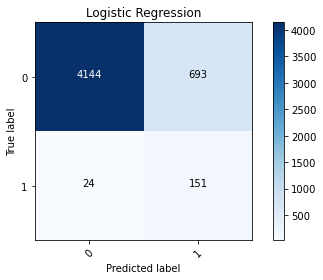

In [13]:
# Look at training results
print(f'f1-score: {round(f1_score(y_train, y_pred_train), 4)}')
plot_confusion_matrix(train_conf_matrix, classes=[0, 1], title='Logistic Regression')

f1-score: 0.2518


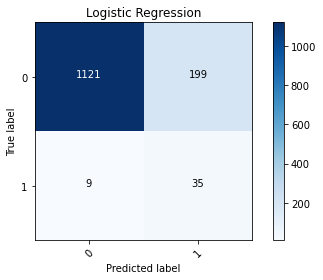

In [14]:
# Look at testing results
print(f'f1-score: {round(f1_score(y_test, y_pred_test), 4)}')
plot_confusion_matrix(test_conf_matrix, classes=[0, 1], title='Logistic Regression')
#False negatives are dangerous!
# Best f1-score = 0.3254

##### Plot ROC Curve for test

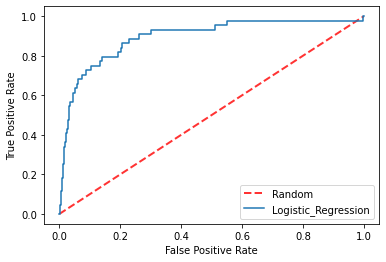

In [15]:
proba_for_each_class = rand_log_reg.predict_proba(X_test)
# calculate the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, proba_for_each_class[:,1])

# plot the line for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=.8)

# plot the ROC Curve for the classifier
plt.plot(fpr,tpr,label='Logistic_Regression')

# show the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show() 

### Pipeline for Random Forest

In [16]:
# Stratified Cross Validation, smote, logistic regression, feature selection with SeleckKBest, 
# hyperparameter optimization with randomized gridsearch

cros_val = StratifiedKFold(n_splits=5)

smote = SMOTE(sampling_strategy='minority', random_state=20)
# Assumption: data has a Gaussian distribution. Therfore use standardscaler and logistic regression.(Might be wrong, but looks better tha minmaxscaler)
scaler =  StandardScaler() # is our data already normalised? (Do not think so). 
# Data seems to be performing well for gaussian methods 

# Data might not be Gaussian --> try minmaxscaler. Results does not improve
scaler2 = MinMaxScaler()

estimator = RandomForestClassifier(random_state=20)
feature_selection = SelectKBest(f_classif) # flere muligheter her? 
pca = PCA() #performs better with PCA

# feature selection before smote. Will smote in pipeline be applied to X_test when using predict? Don't want to balance test data!!!
# Does not look like smote is fited on test set, which is good.

# try and add pca
pipeline = imbpipeline(steps = [('scaler', scaler), ('selection', feature_selection), ('pca', pca), ('smote', smote), 
                        ('forest', estimator)])

# No scaling, gives us very bad results
# pipeline = imbpipeline(steps = [ ('selection', feature_selection), ('smote', smote), ('reg', estimator)])

# For when running gridSearch
params = {'selection__k':[30,40,50,60,70],
          'pca__n_components':[5,7,10,15],
          'forest__max_features' : ['auto', 'sqrt', 'log2'],
          'forest__class_weight' : ['balanced', 'balanced_subsample'],
          'forest__criterion' : ['gini', 'entropy'], 
          'forest__bootstrap' : [True, False]
          }

#best params, add 'forest__max_depth': [5] ?
best_params = {'selection__k':[50],
          'pca__n_components':[15],
          'forest__max_features' : ['log2'],
          'forest__class_weight' : ['balanced_subsample'],
          'forest__criterion' : ['entropy'], 
          'forest__bootstrap' : [False]
          }

rand_forest = GridSearchCV(pipeline, best_params, scoring='f1', cv=cros_val) #for RandomSearchCV: n_jobs=4 ,  verbose=2
# fit rand_log_reg
rand_forest.fit(X_train, y_train)

print(rand_forest.best_params_)
#Best params
#{'forest__bootstrap': False, 'forest__class_weight': 'balanced_subsample', 'forest__criterion': 'entropy', 
# 'forest__max_features': 'log2', 'pca__n_components': 15, 'selection__k': 50}

{'forest__bootstrap': False, 'forest__class_weight': 'balanced_subsample', 'forest__criterion': 'entropy', 'forest__max_features': 'log2', 'pca__n_components': 15, 'selection__k': 50}


In [17]:
y_pred_train = rand_forest.predict(X_train) #prediction on our train set
print(classification_report(y_train, y_pred_train))
train_conf_matrix = confusion_matrix(y_train, y_pred_train)

y_pred_test = rand_forest.predict(X_test) # prediction on our test set
print(classification_report(y_test, y_pred_test))
test_conf_matrix = confusion_matrix(y_test, y_pred_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4837
           1       1.00      1.00      1.00       175

    accuracy                           1.00      5012
   macro avg       1.00      1.00      1.00      5012
weighted avg       1.00      1.00      1.00      5012

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1320
           1       0.34      0.48      0.40        44

    accuracy                           0.95      1364
   macro avg       0.66      0.72      0.69      1364
weighted avg       0.96      0.95      0.96      1364



f1-score: 1.0


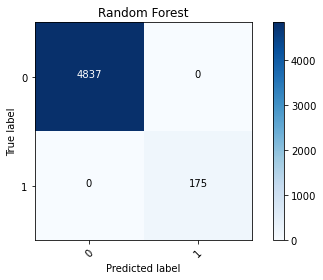

In [18]:
# Look at training results. Can this method be better? Any point in trying other scaling, and feature selecting methodes. 
# Overfitting? And how to deal with it???
print(f'f1-score: {round(f1_score(y_train, y_pred_train), 4)}')
plot_confusion_matrix(train_conf_matrix, classes=[0, 1], title='Random Forest')

f1-score: 0.4


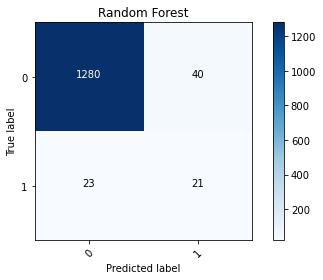

In [19]:
# Look at testing results
print(f'f1-score: {round(f1_score(y_test, y_pred_test), 4)}')
plot_confusion_matrix(test_conf_matrix, classes=[0, 1], title='Random Forest')
#False negatives are dangerous!
# Best f1-score = 0.5053

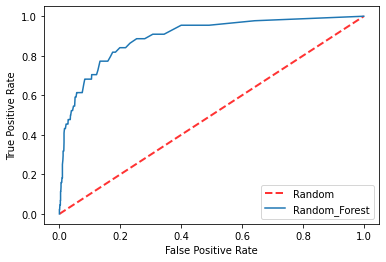

In [20]:
proba_for_each_class = rand_forest.predict_proba(X_test)
# calculate the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, proba_for_each_class[:,1])

# plot the line for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=.8)

# plot the ROC Curve for the classifier
plt.plot(fpr,tpr,label='Random_Forest')

# show the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show() 